In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
# ===== ENV =====
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

llm = ChatGroq(model="llama-3.3-70b-versatile")

result = llm.invoke("What is 2 + 2?")
result


e:\anaconda3\envs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='2 + 2 = 4.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 43, 'total_tokens': 52, 'completion_time': 0.011080616, 'completion_tokens_details': None, 'prompt_time': 0.004263517, 'prompt_tokens_details': None, 'queue_time': 0.058220473, 'total_time': 0.015344133}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c06d5113ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019be39a-dfe5-7360-a6cb-92ad0e62aeff-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 43, 'output_tokens': 9, 'total_tokens': 52})

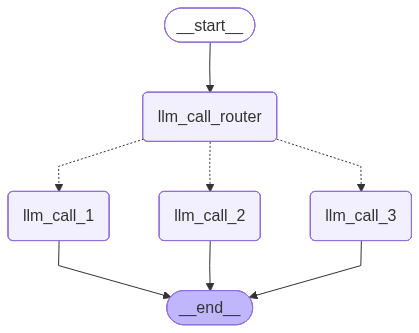

In [5]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from typing import TypedDict

class Route(BaseModel):
  step:Literal["poem","story","joke"] = Field(description="The next in the routing process")

router = llm.with_structured_output(Route)

class State(TypedDict):
    input :str
    decision: str
    output: str

def llm_call_1(state):
   """Write a story"""
   result = llm.invoke(state['input'])
   return {"output": result.content}

def llm_call_2(state):
   """Write a poem"""
   print("LLM call 2 is called")
   result = llm.invoke(state['input'])
   return {"output": result.content}

def llm_call_3(state):
   """Write a joke"""
   result = llm.invoke(state['input'])
   return {"output": result.content}

def llm_call_router(state:State):
   """Router the input to the appropriate node"""
   decision = router.invoke(
      [
         SystemMessage(
            content ="Route the input to story joke or poem based on the user input"
         ),
         HumanMessage(content=state['input'])
      ]
   )
   return {"decision": decision.step}

def router_decision(state:State):
   if state['decision'] == "story":
      return "llm_call_1"
   elif state['decision'] == "poem":
      return "llm_call_2"  
   elif state['decision'] == "joke":
      return "llm_call_3"
   

from langgraph.graph import StateGraph,START,END
from IPython.display import Image, display

router_builder = StateGraph(State)

router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

router_builder.add_edge(START , "llm_call_router")
router_builder.add_conditional_edges(
   "llm_call_router",
   router_decision,
   {
      "llm_call_1": "llm_call_1",
      "llm_call_2": "llm_call_2",
      "llm_call_3": "llm_call_3"
   }
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

router_workflow = router_builder.compile()
display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [6]:
state = router_workflow.invoke({"input":"viết cho tôi 1 joke về Agentic AI systems"})
print(state['output'])

Tại sao hệ thống trí tuệ nhân tạo Agentic lại đi đến bác sĩ?

Vì nó cảm thấy mình đang "lạc lối" trong việc ra quyết định và muốn tìm lại "đường dẫn" đúng! (Agentic AI systems thường liên quan đến khả năng tự chủ và ra quyết định, nên việc "lạc lối" và tìm lại "đường dẫn" là một phép ẩn dụ thú vị cho sự phức tạp của chúng.)
